- 使用3月-11月的数据进行训练，预测11月24的拥堵状况

# 一、导入工具包 

In [1]:
#导入数据处理库
import numpy as np
import pandas as pd
#读取Excel及数据保存为Excel
import openpyxl

In [2]:
#导入绘图工具包
import plotly as py
import plotly.graph_objs as go
#离线绘图
pyplt = py.offline.plot
#随机生成数据
import random
#使得输出的数据可以完整打印出来全部的行列
#显示所有列
#pd.set_option('display.max_columns',None)
#显示所有行
#pd.set_option('display.max_rows',None)
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf  
%matplotlib inline
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3' # 只显示 Error

2024-04-19 21:39:06.617412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 21:39:06.790759: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-19 21:39:07.653609: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: (null error message); LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-04-19 21:39:07.653656: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29]

In [3]:
# 设置gpu内存自增长
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[]


2024-04-19 21:39:12.341536: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-04-19 21:39:12.355073: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-04-19 21:39:12.368210: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-04-19 21:39:12.546238: W tensorflow/compiler/xla/stream_executor/platform/defa

# 二、读入数据

In [75]:
number = 54

In [76]:
#读取某条路径的全部数据
corrected_roadData = pd.read_csv(r'./data/road%d.csv'%number)

In [77]:
corrected_roadData

,date,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,EXPONENT
0,2018/7/1 0:00,0,0,0,0,0,0,1,3
1,2018/7/1 0:05,0,0,0,0,0,0,1,3
2,2018/7/1 0:10,0,0,0,0,0,0,1,2
3,2018/7/1 0:15,0,0,0,0,0,0,1,3
4,2018/7/1 0:20,0,0,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...
42043,2018/11/23 23:35,0,0,0,0,0,1,0,2
42044,2018/11/23 23:40,0,0,0,0,0,1,0,2
42045,2018/11/23 23:45,0,0,0,0,0,1,0,2
42046,2018/11/23 23:50,0,0,0,0,0,1,0,2


# 三、处理数据

In [78]:
#输入数据的长度，用前3天的数据预测24小时以后的一个时刻的数据，每天有288个观测值
sequence_len = 3 * 288   #训练数据：从当前时间点来看前面5天的数据
delay = 288  #预测数据：从当前时间点来看后一天的数据
for_predict = (5 * 288 - 1)  #用于预测的数据，不参与模型训练和验证

In [79]:
#因为是一个单输入和单输出，所以只需要提取出roadData中的第三列数据，然后重新赋值给roadData即可
#此时输出的结果是一个二维array数组
roadData_array = corrected_roadData.iloc[:,1:].values
roadData_array

array([[0, 0, 0, ..., 0, 1, 3],
       [0, 0, 0, ..., 0, 1, 3],
       [0, 0, 0, ..., 0, 1, 2],
       ...,
       [0, 0, 0, ..., 1, 0, 2],
       [0, 0, 0, ..., 1, 0, 2],
       [0, 0, 0, ..., 1, 0, 2]])

In [80]:
#创建一个空列表data_，每六天的数据为一组（共1152条），将全部数据（共76032条）去除用于预测的数据（2015条）进行划分（全部数据量/六天的数据总量）组，每条数据只有一个变量
data_ = []
for i in range(len(roadData_array)-sequence_len-delay-for_predict):
    data_.append(roadData_array[i:i+sequence_len+delay])
#把data_转化为array数组，三维（全部数据量，每组数据量，每条数据所含变量）
data_ = np.array(data_)

In [81]:
#把全部组的数据的顺序打乱
np.random.shuffle(data_)

In [82]:
#高维数组切片，切出x（特征）和y（标签）
x = data_[: , :3*288, : ]

In [83]:
y = data_[: ,-1, 7:]

In [84]:
x.shape

(39457, 864, 8)

In [85]:
y.shape

(39457, 1)

In [86]:
#划分训练数据和测试数据，其中，80%为训练数据，20%为测试数据
split_b = int(data_.shape[0]*0.8)

In [87]:
train_x = x[ : split_b]
train_y = y[ : split_b]
test_x = x[split_b : ]
test_y = y[split_b : ]


In [88]:
train_x.shape , train_y.shape

((31565, 864, 8), (31565, 1))

In [89]:
test_x.shape , test_y.shape

((7892, 864, 8), (7892, 1))

In [90]:
#神经网络喜欢分布在一定范围内的数据，所以要进行数据标准化。
#在进行数据标准化过程中需要注意，我们不可能生活在未来，因此标准化减均值除方差的均值和方差应该是训练集上的，不应该包含测试集数据
mean = train_x.mean(axis = 0)  #求列上的均值

In [91]:
mean

array([[0.14687153, 0.14585775, 0.13819103, ..., 0.13809599, 0.14677649,
        3.03377158],
       [0.14680817, 0.14582607, 0.13822272, ..., 0.13822272, 0.14674481,
        3.03586251],
       [0.14683985, 0.14579439, 0.1382544 , ..., 0.13815935, 0.14671313,
        3.03557738],
       ...,
       [0.13781087, 0.1382544 , 0.13933154, ..., 0.14522414, 0.14630128,
        3.02977982],
       [0.13781087, 0.13819103, 0.13933154, ..., 0.1451291 , 0.14645969,
        3.02886108],
       [0.13777919, 0.13822272, 0.13929986, ..., 0.14531918, 0.14639633,
        3.02765722]])

In [92]:
std = train_x.std(axis = 0,dtype=float)  #求列上的方差

In [93]:
std

array([[0.35397781, 0.35296355, 0.34510038, ..., 0.34500071, 0.35388297,
        1.3905385 ],
       [0.35391459, 0.35293176, 0.34513359, ..., 0.34513359, 0.35385134,
        1.38711003],
       [0.3539462 , 0.35289997, 0.3451668 , ..., 0.34506716, 0.35381971,
        1.38874942],
       ...,
       [0.34470137, 0.3451668 , 0.34629216, ..., 0.35232668, 0.353408  ,
        1.38661437],
       [0.34470137, 0.34510038, 0.34629216, ..., 0.35223095, 0.35356647,
        1.38824359],
       [0.34466807, 0.34513359, 0.34625916, ..., 0.35242236, 0.3535031 ,
        1.38872442]])

In [94]:
train_x = (train_x -mean)/std

In [95]:
test_x = (test_x - mean)/std

In [96]:
train_x.shape

(31565, 864, 8)

In [97]:
train_y.shape

(31565, 1)

# （五）建立模型

### 2.LSTM 

In [98]:
model1 = keras.Sequential()

In [99]:
#LSTM网络dense层接受的数据就是三维的
model1.add(layers.LSTM(96,input_shape = (train_x.shape[1:]))) #32是隐藏单元数，默认激活函数是tanh
model1.add(layers.Dense(1))

In [100]:
#使用一个回调函数，在学习中降低学习速率，让前期快速下降，后期缓慢下降，避免错过最优值
#监控'val_loss'，如果连续3个'val_loss'不变，就降低学习速率，降低为原来的factor倍，降低到min_lr就停止降低
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience = 3, factor=0.5, min_lr=0.000001)  

In [101]:
#创建EarlyStopping回调函数,monitor参数表示需要监视的指标，一般选择验证集上的损失函数；
#patience参数表示当指标不再提升时，模型需要多少个Epoch才停止训练。
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [102]:
from keras.callbacks import TensorBoard
# 创建TensorBoard回调函数
tensorboard_callback = TensorBoard(log_dir='logs')

In [103]:
model1.compile(optimizer = 'rmsprop',
             loss = 'mae',
             metrics = ['mae'])

In [104]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 96)                40320     
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 40,417
Trainable params: 40,417
Non-trainable params: 0
_________________________________________________________________


In [105]:
import time
start_time = time.time()
history1 = model1.fit(train_x.astype(np.float32),train_y.astype(np.float32),
                    batch_size = 128,
                    epochs = 60,
                    callbacks = [lr_reduce,early_stopping],
                    validation_data = (test_x.astype(np.float32), test_y.astype(np.float32)))

Epoch 1/60
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
247/247 [==============================] - ETA: 0s - loss: 0.7855 - mae: 0.7855WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f56a8217cb0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
247/247 [==============================] - 206s 827ms/step - loss: 0.7855 - mae: 0.7855 - val_loss: 0.7137 - val_mae: 0.7137 - lr: 0.0010
Epoch 2/60
247/247 [==============================] - 205s 832ms/step - loss: 0.7020 - mae: 0.7020 - val_loss: 0.7130 - val_mae: 0.7130 - lr: 0.0010
Epoch 3/60
247/247 [==============================] - 201s 814ms/step - loss: 0.6873 - mae: 0.6873 - val_loss: 0.7040 - val_mae: 0.7040 - lr: 0.0010
Epoch 4/60
247/247 [==============================] - 202s 820ms/step - loss: 0.6768 - mae: 0.6768 - val_loss: 0.6882 - val_mae: 0.6882 - lr: 0.0010
Epoch 5/60
247/247 [==============================] - 205s 828ms/step - loss: 0.6684 - mae: 0.6684 - val

In [107]:
end_time = time.time()
run_time = end_time - start_time
print("模型训练时间为：{:.2f}秒".format(run_time))

模型训练时间为：12672.57秒


In [108]:
history1.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])

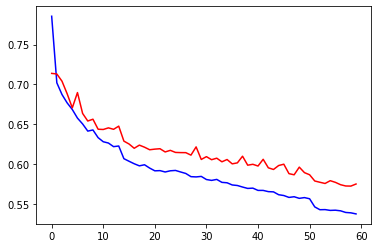

In [109]:
plt.plot(history1.epoch,history1.history['mae'],c='b')
plt.plot(history1.epoch,history1.history['val_mae'],c='r')

model1.evaluate(test_x.astype(np.float32), test_y.astype(np.float32),verbose =0)

In [110]:
#保存模型
model1.save('TCI_prediction_road%d_model'%number)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: TCI_prediction_road54_model/assets


INFO:tensorflow:Assets written to: TCI_prediction_road54_model/assets


# （六）数据预测

In [111]:
corrected_roadData.tail(288*5-1)

,date,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,EXPONENT
40609,2018/11/19 0:05,0,1,0,0,0,0,0,2
40610,2018/11/19 0:10,0,1,0,0,0,0,0,1
40611,2018/11/19 0:15,0,1,0,0,0,0,0,2
40612,2018/11/19 0:20,0,1,0,0,0,0,0,2
40613,2018/11/19 0:25,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
42043,2018/11/23 23:35,0,0,0,0,0,1,0,2
42044,2018/11/23 23:40,0,0,0,0,0,1,0,2
42045,2018/11/23 23:45,0,0,0,0,0,1,0,2
42046,2018/11/23 23:50,0,0,0,0,0,1,0,2


In [112]:
#因为是一个单输入和单输出，所以只需要提取出roadData中的第三列数据，然后重新赋值给roadData即可
#因为要预测2018年11月24日的数据，因此获取后面的倒数288*5天的数据
#此时输出的结果是一个二维array数组
for_predict_roadData = corrected_roadData.iloc[40609:,1:].values
for_predict_roadData

array([[0, 1, 0, ..., 0, 0, 2],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 2],
       ...,
       [0, 0, 0, ..., 1, 0, 2],
       [0, 0, 0, ..., 1, 0, 2],
       [0, 0, 0, ..., 1, 0, 2]])

In [113]:
for_predict_roadData.shape

(1439, 8)

In [114]:
#创建一个空列表for_predict_data_，每六天的数据为一组（共1152条），将全部数据（共76032条）去除用于预测的数据（2015条）进行划分（全部数据量/六天的数据总量）组，每条数据只有一个变量
for_predict_data_= []
for i in range(len(for_predict_roadData)-sequence_len-delay+1):
    for_predict_data_.append(for_predict_roadData[i:i+sequence_len+delay])
#把data_转化为array数组，三维（全部数据量，每组数据量，每条数据所含变量）
for_predict_data_ = np.array(for_predict_data_)

In [115]:
for_predict_data_.shape

(288, 1152, 8)

In [116]:
#高维数组切片，切出x（特征）和y（标签）
for_predict_x = for_predict_data_[: , :3*288, : ]

In [117]:
for_predict_y = for_predict_data_[: ,-1, 7:]

In [118]:
for_predict_x 

array([[[0, 1, 0, ..., 0, 0, 2],
        [0, 1, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 2],
        ...,
        [0, 0, 0, ..., 0, 0, 3],
        [0, 0, 0, ..., 0, 0, 2],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 1, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 2],
        [0, 1, 0, ..., 0, 0, 2],
        ...,
        [0, 0, 0, ..., 0, 0, 2],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 1, 0, ..., 0, 0, 2],
        [0, 1, 0, ..., 0, 0, 2],
        [0, 1, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       ...,

       [[0, 1, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 2],
        [0, 0, 1, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 2],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 1, 0, ..., 0, 0, 2],
        [0, 0, 1, ..., 0, 0, 1],
        [0, 0, 1, ..., 0, 0, 2],
        ...,
        [0, 0, 0, ..., 

In [119]:
for_predict_x = (for_predict_x - mean)/std

In [120]:
for_predict_y

array([[1],
       [1],
       [2],
       [2],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [2],
       [1],
       [3],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [2],
       [3],
       [1],
       [3],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [3],
       [1],
       [1],
       [2],
       [3],
       [3],
       [4],
       [3],
       [1],
       [3],
       [1],
       [3],
       [3],
       [1],
       [2],
       [2],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [3],
       [2],
       [2],
       [2],
       [1],
       [1],
       [2],
       [3],
       [3],
       [2],
       [1],
    

In [121]:
#一次性预测未来多个时刻的数据
pre_test = model1.predict(for_predict_x.astype(np.float32))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9/9 [==============================] - 1s 121ms/step


In [122]:
pre_test.shape

(288, 1)

In [123]:
print(pre_test)

[[1.9221141 ]
 [1.9387088 ]
 [1.9343488 ]
 [1.9401145 ]
 [1.9083364 ]
 [1.8026228 ]
 [1.6663909 ]
 [1.5083566 ]
 [1.3256385 ]
 [1.1913064 ]
 [1.086967  ]
 [1.0257354 ]
 [1.0138752 ]
 [1.0086215 ]
 [1.0114441 ]
 [1.015095  ]
 [1.0183607 ]
 [1.0209993 ]
 [1.0261707 ]
 [1.0097994 ]
 [1.0254264 ]
 [1.0241988 ]
 [1.0254836 ]
 [1.0300192 ]
 [1.0244346 ]
 [1.0121044 ]
 [1.0279132 ]
 [1.0148048 ]
 [1.0255587 ]
 [0.9979332 ]
 [1.0170767 ]
 [1.004614  ]
 [1.0083373 ]
 [1.0095274 ]
 [1.0118749 ]
 [1.0146654 ]
 [1.0172911 ]
 [1.0194237 ]
 [1.0208163 ]
 [1.0213714 ]
 [1.0217888 ]
 [1.0184412 ]
 [1.0179843 ]
 [1.0144331 ]
 [1.0062296 ]
 [0.99267197]
 [0.9850636 ]
 [0.9823799 ]
 [1.0222285 ]
 [1.0369225 ]
 [1.03375   ]
 [1.0310749 ]
 [1.0290482 ]
 [1.0275764 ]
 [1.0265753 ]
 [1.0262008 ]
 [1.0261731 ]
 [1.0263741 ]
 [1.0268724 ]
 [1.0471197 ]
 [1.1497705 ]
 [1.2842999 ]
 [1.4590375 ]
 [1.7579916 ]
 [1.8838174 ]
 [1.9562495 ]
 [1.9845057 ]
 [1.9974082 ]
 [1.9940434 ]
 [2.001395  ]
 [2.0000153 ]
 [1.98

In [124]:
pre_test = np.round(pre_test)

In [125]:
#把二维转化为一维
pre_test = [i for arr in pre_test for i in arr ]
pre_test

[2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0

In [126]:
print(pre_test)

[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0,

In [127]:
len(pre_test)

288

In [128]:
future_real_y = (corrected_roadData.tail(288)).EXPONENT.values

In [129]:
future_real_y

array([1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 3, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 3, 1, 3, 1, 2, 2, 2, 2,
       1, 3, 1, 1, 2, 3, 3, 4, 3, 1, 3, 1, 3, 3, 1, 2, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 2, 2, 3, 2, 2, 2, 1, 1, 2, 3, 3, 2, 1, 2, 2, 1, 2, 3,
       3, 3, 4, 3, 4, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 3, 3, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 4, 4, 4, 3, 4, 3, 3, 3, 4, 4, 4, 4, 3, 4, 3, 2, 3, 3, 2, 3, 2,
       3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 3, 4, 4, 4, 4, 4, 5, 4, 3, 4, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 5,
       5, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 2,
       2, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2])

In [130]:
sum1=0
sum2=0
for i in range(0,288):
    if future_real_y[i] == for_predict_y[i]:
        sum1+=1
    if future_real_y[i] == pre_test[i]:
        sum2+=1    
print(sum1,sum2)
print('预测的正确率为：' + str(sum2/sum1))

288 178
预测的正确率为：0.6180555555555556


# （七）把预测的数据写入Excel文件

In [131]:
from openpyxl import Workbook
#将数据写入到Excel并保存
wb = Workbook()
sheet1 = wb.active
sheet1.title = 'road%d'%number
col_name = ['TCI_prediction_of_road%d'%number]   #注意修改此处
variable_name = [pre_test]
for j in range(1,len(col_name)+1):
    sheet1.cell(1,j,col_name[j-1])
    for i in range(2,len(variable_name[j-1])+2):
        sheet1.cell(i,j,variable_name[j-1][i-2])
wb.save('TCI_prediction_of_road%d.xlsx'%number)
print('已保存')

已保存


# 八、加载已有模型进行预测 

In [ ]:
from keras.models import load_model 

In [ ]:
model = load_model("TCI_prediction_road%d_model"%number)